# Analysing and Predicting the Women's World Cup

<ul>
<li><a href="#motivation">Motivation</a></li>
    <ul>
    <li><a href="#requirements">Requirements</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
    <li><a href="#question_1">Item if needed</a></li>
    </ul>
<li><a href="#modeling">Modeling</a></li>
    <ul>
    <li><a href="#preparation">Data Preparation</a></li>
    <li><a href="#preprocess">Preprocessing</a></li>
    <li><a href="#features">Features</a></li>
    <li><a href="#model_selection">Model Selection</a></li>
    </ul>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='motivation'></a>
## Motivation

The FIFA Women's World Cup is in its eighth edition in 2019. It occurs every four years between June and July, and has teams from all continents. This edition is being held in France, and 24 teams qualified for the final tournament ([Wikipedia](https://en.wikipedia.org/wiki/2019_FIFA_Women%27s_World_Cup)).

Besides the similarities, the women's football is not even close to have the same visibility as the men's one (at least not in Brazil, but we imagine that it's the same in the whole world), and founding the data about previous matches wasn't very easy. There wasn't data available on FIFA's website or in any other "official" provider, but we found it on [Kaggle](https://www.kaggle.com/alexkaechele/womens-world-cup) (thanks a lot for inputing this data by hand).

This analysis and modeling has the intent of predicting the winners from the round of 16 to the final match. The data and code used is provided on our Github.

We are very excited to know who is going to win, and we hope you enjoy the results as much as we did working on it.

<a id='requirements'></a>
### Requirements

**python 3.7.3**

* matplotlib==3.0.3
* numpy==1.16.3
* pandas==0.24.2
* seaborn==0.9.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.core.display import display, HTML

import plots as ps

sns.set()
sns.set_palette("GnBu_d", 6)
%matplotlib inline

def create_link(id):
    display(HTML(f'<a id={id}></a>'))

---
Loading data

In [2]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

<a id='wrangling'></a>
## Data Wrangling

In [3]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

display(scores_raw.shape)
display(ranking.shape)

(354, 7)

(150, 3)

In [4]:
scores_raw.head(3)

,Team_i,Team_j,home_i,home_j,score_i,score_j,year
0,china,thailand,0,0,4,0,2018
1,jordan,philippines,1,0,1,2,2018
2,philippines,china,0,0,0,3,2018


In [5]:
ranking.head(3)

,rank,team,rating
0,1,United States,2101
1,2,Germany,2072
2,3,England,2049


The countries'names in `ranking` data have upper case letters, we are going to make it consistent with the `scores` data by changing them to lower case.

In [6]:
ranking.team = ranking.team.apply(lambda x: x.lower())
ranking.head(3)

,rank,team,rating
0,1,united states,2101
1,2,germany,2072
2,3,england,2049


#### Merging the DataFrames

In order to make easy to analyse the data, we are going to merge the DFs.

In [7]:
all_matches_i_j = (scores_raw.merge(ranking, left_on='Team_i', right_on='team')
                             .rename(columns={'Team_i': 'team_i',
                                              'rating': 'rating_i',
                                              'rank': 'rank_i'})
                             .drop(columns=['team'])
                             .merge(ranking, left_on='Team_j', right_on='team')
                             .rename(columns={'Team_j': 'team_j',
                                              'rating': 'rating_j',
                                              'rank': 'rank_j'})
                             .drop(columns=['team']))


all_matches = all_matches_i_j.rename(columns={'team_i': 'team_a',
                                              'home_i': 'home_a',
                                              'score_i': 'score_a',
                                              'rank_i': 'rank_a',
                                              'rating_i': 'rating_a',
                                              'team_j': 'team_b',
                                              'home_j': 'home_b',
                                              'score_j': 'score_b',
                                              'rank_j': 'rank_b',
                                              'rating_j': 'rating_b',})

display(all_matches.head())
display(all_matches.shape)

,team_a,team_b,home_a,home_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,0,0,4,0,2018,16,1866,34,1658
1,china,thailand,0,0,3,1,2018,16,1866,34,1658
2,australia,thailand,0,0,2,2,2018,6,2003,34,1658
3,united states,thailand,0,0,13,0,2019,1,2101,34,1658
4,sweden,thailand,0,0,5,1,2019,9,1962,34,1658


(354, 11)

<a id=''></a>
## Exploratory Data Analysis

Here are some questions we are going to address in this section:

[1. *Is a team more likely to win when playing at home?*](#question_1)

[2. *How many matches happened per year?*](#question_2)

[3. *Which are the teams with the most winnings?*](#question_3)

[4. *Which are the teams with the most loss?*](#question_4)

[5. *Higher ratings are related with more wins?*](#question_5)

[6. *How are the scores distributions?*](#question_6)

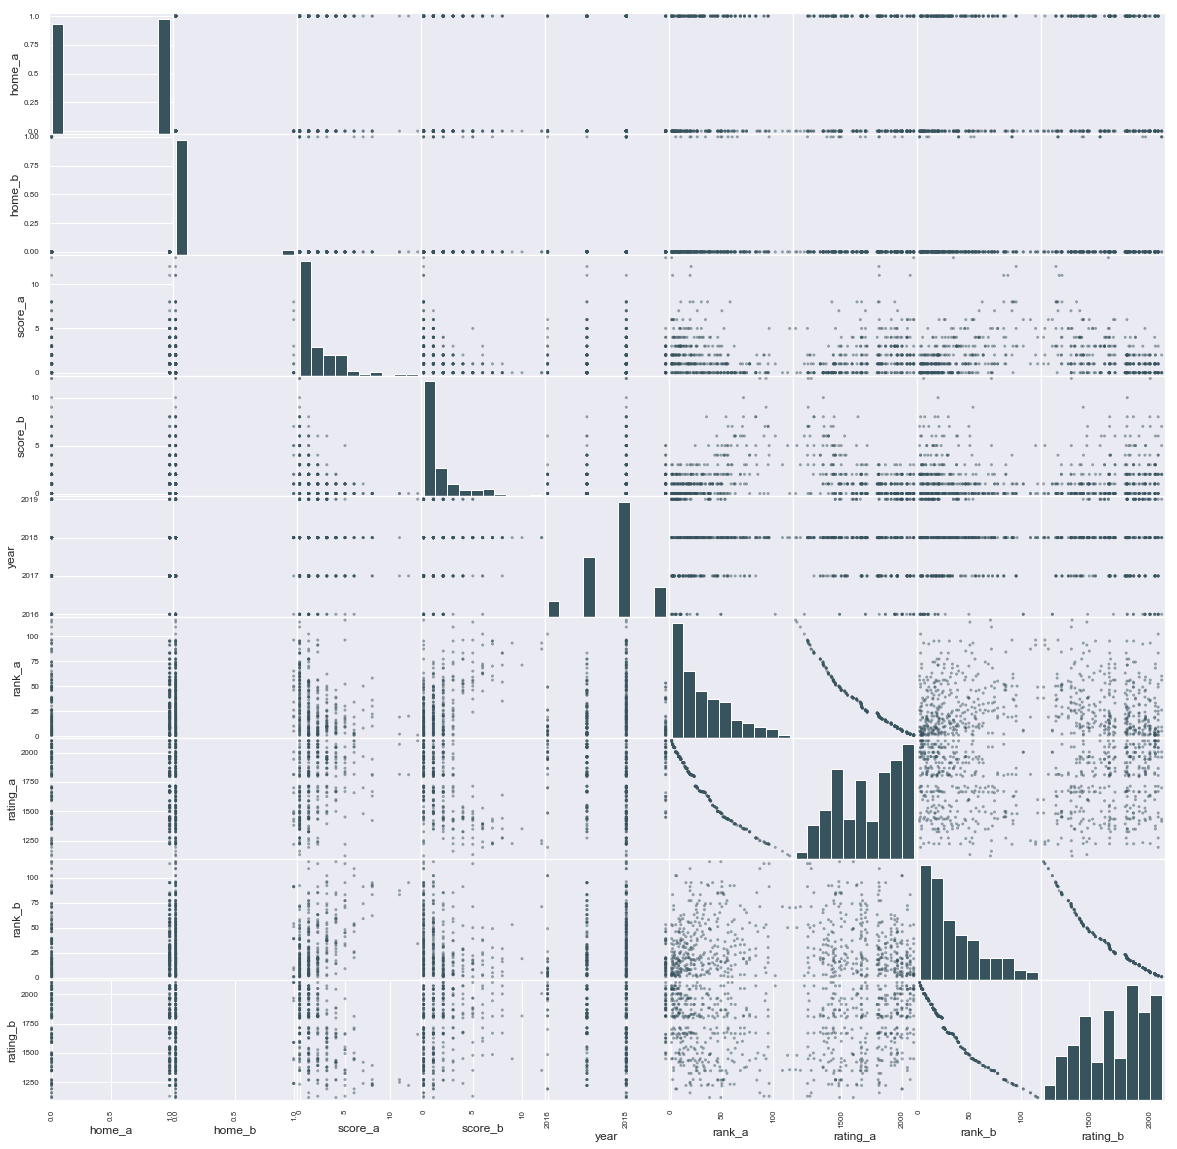

In [8]:
pd.plotting.scatter_matrix(all_matches, figsize=(20,20));

Some points:

countries with more rating play more games. as we can see in `rating_i X rating_i` *(equal to rank_i, rating_j and rank_j)*

There are more games at 2018.

There are some correlations between scores of A and rating that 

In [9]:
all_matches.sample(2, random_state=23)

,team_a,team_b,home_a,home_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
334,faroe islands,slovenia,1,0,0,4,2018,83,1272,52,1451
286,northern ireland,ireland,1,0,0,2,2017,59,1420,31,1666


<a id='modeling'></a>
## Modeling

###  Data Preparation

**Guarantee that team I and team J respect lexical order**

Above we can see that the `scores_raw` contains a row for every match, including the teams, if the team played at home, the scores, and the year. As the world cup is held in one country, we do not consider the data about playing in home relevant for this prediction, that's why we are going to drop it.

In [10]:
scores = scores_raw.drop(columns=['home_i', 'home_j'])
display(scores.head(3))

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,philippines,china,0,3,2018


In [11]:
scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_i', 'score_i', 'Team_j', 'score_j']] = \
    scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_j', 'score_j', 'Team_i', 'score_i']].values
        

scores.head()

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,china,philippines,3,0,2018
3,jordan,thailand,1,6,2018
4,china,jordan,8,1,2018


For this first model we want to predict which team wons the match.

So, for that we are going to create a column target which says which one wins.

In [12]:
all_matches['target'] = 'draw'
all_matches.loc[all_matches.score_a > all_matches.score_b, ['target']] = 'win_a'
all_matches.loc[all_matches.score_a < all_matches.score_b, ['target']] = 'win_b'
print(f"amount of target values: {all_matches['target'].nunique()}")

amount of target values: 3


In [13]:
for c in all_matches.columns:
    print(f'{c} = {all_matches[c].unique()} \n')

team_a = ['china' 'australia' 'united states' 'sweden' 'south korea' 'brazil'
 'argentina' 'chile' 'netherlands' 'denmark' 'ukraine' 'hungary' 'croatia'
 'germany' 'south africa' 'canada' 'russia' 'faroe islands' 'iceland'
 'czech republic' 'slovenia' 'zimbabwe' 'france' 'england' 'scotland'
 'serbia' 'finland' 'israel' 'austria' 'jordan' 'thailand' 'philippines'
 'nigeria' 'colombia' 'peru' 'japan' 'vietnam' 'jamaica' 'kazakhstan'
 'wales' 'bosnia and herzegovina' 'portugal' 'albania' 'poland' 'belarus'
 'switzerland' 'cameroon' 'fiji' 'ecuador' 'belgium' 'romania' 'moldova'
 'bolivia' 'italy' 'northern ireland' 'slovakia' 'ireland' 'ghana'
 'algeria' 'mali' 'equatorial guinea' 'norway' 'spain' 'new zealand'
 'zambia' 'trinidad' 'panama' 'cuba' 'costa rica' 'mexico' 'paraguay'
 'uruguay' 'venezuela' 'samoa' 'new caledonia' 'tahiti' 'papua new guinea'
 'cook islands' 'tonga'] 

team_b = ['thailand' 'japan' 'sweden' 'germany' 'spain' 'philippines' 'china'
 'south korea' 'jordan' 'chile'

We defined ratings as continuous variable and all others are going to be categorical.

In [14]:
X_raw = all_matches.drop(columns=['target', 'score_a', 'score_b'])
y_raw = all_matches['target']

display(X_raw.shape)
display(X_raw.sample(3, random_state=13))

display(y_raw.shape)
display(y_raw.sample(3, random_state=13))

(354, 9)

,team_a,team_b,home_a,home_b,year,rank_a,rating_a,rank_b,rating_b
259,scotland,belarus,1,0,2018,20,1812,55,1436
245,poland,switzerland,1,0,2018,28,1676,18,1828
99,canada,new zealand,0,0,2019,5,2006,19,1815


(354,)

259    win_a
245     draw
99     win_a
Name: target, dtype: object

### Features

In [15]:
# enconding categorical features with one hot encoder
feat_cats = (pd.get_dummies(X_raw[['team_a',
                                   'team_b', 'year']].astype(str)))
print('shape categorycal:')
display(feat_cats.shape)

# normalization numerical features
from sklearn import preprocessing

feat_nums_raw = preprocessing.scale(X_raw[['rating_a', 'rating_b']])
feat_nums = pd.DataFrame(feat_nums_raw, columns=['rating_a', 'rating_b'])
print('describe numerical:')
display(feat_nums.describe())

# merging data
X = feat_nums.join(feat_cats)
print('shape all merged:')
display(X.shape)

shape categorycal:


(354, 162)

describe numerical:


,rating_a,rating_b
count,3.540000e+02,3.540000e+02
mean,-2.408619e-16,-3.211493e-16
std,1.001415e+00,1.001415e+00
min,-2.302348e+00,-2.208639e+00
25%,-8.968847e-01,-8.410768e-01
50%,2.891236e-01,4.973833e-02
75%,9.150459e-01,8.151935e-01
max,1.445553e+00,1.521768e+00


shape all merged:


(354, 164)

##### About Cross Validation

We have to realize that we have few data points, because of that we are NOT follow the default data split:
`Train | Cross Validation | Test`

We are going to use kfold trying to not throw data away. We will define 5 buckets and then we are going to train each algorithm proposed 5 times, using k-1 bucket, and evaluate metric with the one that remains. In conclusion, we will have 5 metrics for each model, the final metric for each model is the average of those metrics. After that, we are going to compare each model to choose the best one.

We will using Stratified Kfold to guarantee that classes are equally devided among the folds.

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=23)
k_fold_indexes = [(train, test) for train, test in kf.split(X, y_raw)]

labels=['win_a', 'draw', 'win_b']

def train_model_k_fold(model, score, train_data=X, target_data=y_raw):
    scores = []
    confusion_matrixes = []
    
    for train, test in k_fold_indexes:       
        X_train, X_test, y_train, y_test = \
            train_data.loc[train], train_data.loc[test], target_data.loc[train], target_data.loc[test]
        
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        
    return np.mean(scores)

## The Model - First Scene - Compare some algorithms

Decision Tree: 0.610079365079365
Logistic Regression: 0.7285714285714284
SVC kernel=linear: 0.6494444444444445
SVC kernel=poly: 0.4661904761904762
SVC kernel=rbf: 0.7172222222222222
SVC kernel=sigmoid: 0.6972222222222222
Random Forest: 0.615952380952381
Gradient Boosting: 0.6468253968253969


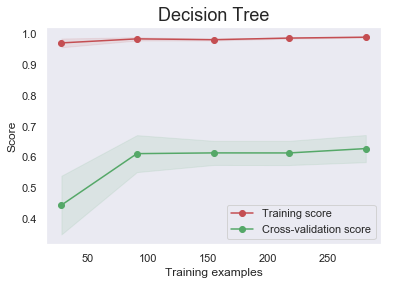

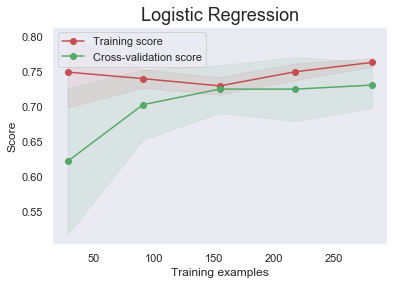

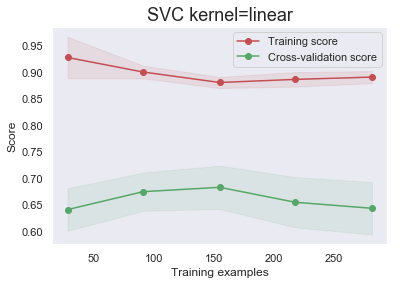

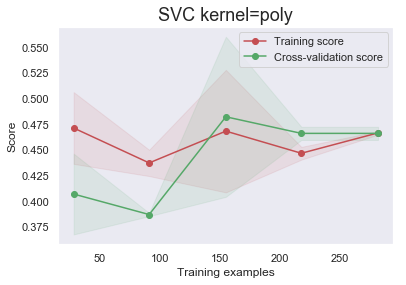

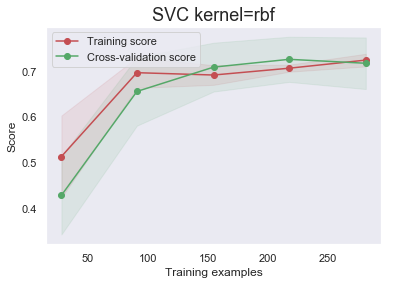

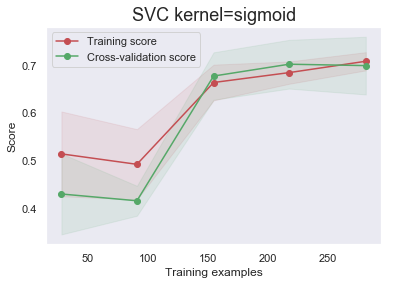

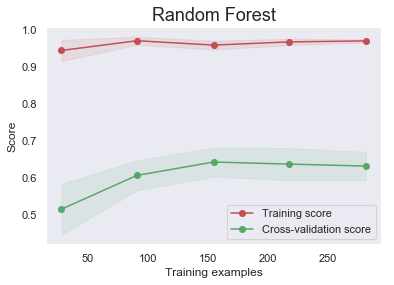

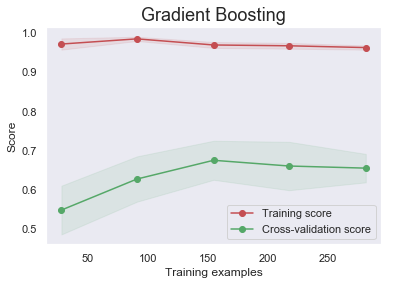

In [17]:
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = []

models.append(("Decision Tree", DecisionTreeClassifier(random_state=4)))
models.append(("Logistic Regression", LogisticRegression(solver='lbfgs', C=0.1, multi_class='auto', random_state=4)))
models.append(("SVC kernel=linear", SVC(kernel='linear', random_state=4)))
models.append(("SVC kernel=poly", SVC(kernel='poly', gamma='auto', random_state=23)))
models.append(("SVC kernel=rbf", SVC(kernel='rbf', gamma='auto', random_state=4)))
models.append(("SVC kernel=sigmoid", SVC(kernel='sigmoid', gamma='auto', random_state=4)))
models.append(("Random Forest", RandomForestClassifier(n_estimators=10, random_state=4)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=4)))


for name, model in models:
    print(f'{name}: {train_model_k_fold(model, accuracy_score)}')
    ps.plot_learning_curve(model, name, X, y_raw, cv=k_fold_indexes)


### Model Analysis

#### Decision Tree
`accuracy = 0.60`

Learning Curve show us that model extremelly overfits the data, the gap between the curves show this, so the model has high variance and acquiring more data could help this overfits behavior. But, decision trees tend to overfit a lot, even more when we don't do feature selection, like we didn't.

#### Logistic Regression
`accuracy = 0.73`

Learning Curve shows a very nice pattern: high score with close curves. We made a simple hyper parameter tunning at this stage (cheating, ok!) tunning C to regularize our 230+ features =D. Model answers very nice for our propose, one of the best choices.

#### SVC
`kernel: linear -> accuracy = 0.68`

`kernel: poly -> accuracy = 0.65`

`kernel: rbf -> accuracy = 0.72`

`kernel: sigmoid -> accuracy = 0.72`

At this point we made a simple hyper parameter tunning again (cheating), at my point of view, does no make sense choose an SVM model without choose a kernel, so we create 4 svc models, one for each basic kernel that has in sklearn.

Linear kernel has high variance (overfit the data) and poly kernel has high bias (underfit the data). Sigmoid and rbf are both nice!

#### Ensemble Methods
`Gradient Boosting -> accuracy = 0.66`

`Random Forest -> accuracy = 0.64`

Both have good metrics, but is easy to see in learning curves that both are overfitted. Both cases, I think that more data could fix this overfitting problem, sadly we don't have more data, so let's move on.

### Final Comments

There are a bunch of other models that we could explore, but at this point, for our propose, those are enough to find a good solution.

I decided to stress Linear Regression and SVC with sigmoid kernel to the next stages.

## The Model - Second Scene - Stressing some algorithms

At this part we will find the best hyper parameters to chossed models. 

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(accuracy_score)

### Linear Regression

In [36]:
parameters_lr = {'solver': ('newton-cg', 'sag', 'saga', 'lbfgs'),
              'C': np.unique(np.geomspace(0.001, 1, num=15, dtype=float)),
              'max_iter': np.unique(np.geomspace(50, 200, num=3, dtype=int))}

lr = LogisticRegression(multi_class='auto')

gd_model_lr = GridSearchCV(lr,
                           parameters_lr,
                           n_jobs=8,
                           cv=k_fold_indexes,
                           iid=True,
                           scoring=scorer,
                           verbose=1)
gd_model_lr.fit(X, y_raw)

display(gd_model_lr.best_estimator_)
gd_model_lr.best_score_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:    2.8s finished


LogisticRegression(C=0.011787686347935873, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=49, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

0.7259887005649718

## SVC

In [ ]:
parameters_scv = {'kernel': ('sigmoid', 'rbf'),
                  'C': np.unique(np.geomspace(0.001, 1, num=10, dtype=float)),
                  'coef0': np.unique(np.geomspace(0.01, 10, num=5, dtype=float)),
                  'class_weight': (None,
                                   'balanced',
                                   {'win_a': (354/(354-151)), 'win_b': (354/(354-151)), 'draw': (354/(354-52))}),
                  'gamma': list(np.unique(np.geomspace(0.0001, 10, num=10, dtype=float))) + ['scale'],
                  'tol': np.unique(np.geomspace(0.0001, 10, num=6, dtype=float))}


svc = SVC(kernel='linear', decision_function_shape='ovo', random_state=4)

gd_model_svc = GridSearchCV(svc,
                            parameters_scv,
                            n_jobs=8,
                            cv=k_fold_indexes,
                            iid=True,
                            scoring=scorer,
                            verbose=1)
gd_model_svc.fit(X, y_raw)


display(gd_model_svc.best_estimator_)
gd_model_svc.best_score_

Fitting 4 folds for each of 19800 candidates, totalling 79200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 268 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2368 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 5868 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done 10768 tasks      | elapsed:   28.2s
[Parallel(n_jobs=8)]: Done 17068 tasks      | elapsed:   45.2s
[Parallel(n_jobs=8)]: Done 24768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 33868 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 44368 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 56268 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 69568 tasks      | elapsed:  3.0min


In [ ]:
best_model = gd_model_svc.best_estimator_
print(f'Accuracy error: {train_model_k_fold(best_model, accuracy_score)}')
ps.plot_learning_curve(best_model, 'Final Model - Learning Curve', X, y_raw, cv=k_fold_indexes);

#### Feature importance based on decision tree model

In [ ]:
dt_model = DecisionTreeClassifier(random_state=4)
dt_model.fit(X, y_raw)

feature_importance = [(f, importance) for f, importance in zip(X.columns, dt_model.feature_importances_)]

relevant_features = [f for f, i in feature_importance if i>0]
best_features = [f for f, i in feature_importance if i>0.01]
best_features
# relevant_features = [f, importance for f, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True)]

# for f, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True):
#     if importance > 0:
#         print(f, importance)

In [ ]:
from sklearn.metrics import confusion_matrix
labels=['win_a', 'draw', 'win_b']
cm1=confusion_matrix(y_test, pred, labels=labels)
cm2=confusion_matrix(y_test, pred, labels=labels)

In [ ]:
import plots as ps

from importlib import reload
reload(ps)

ps.print_confusion_matrixes([cm1, cm2, cm2, cm2, cm2], labels)

In [ ]:
ax[i]